In [1]:
# Lendo os Dados
import pandas as pd
df = pd.read_csv('/datasets/Churn.csv')
print(df.head())
print(df.info())
print(df.isna().sum())

print(f"Valores ausentes em Tenure: {df['Tenure'].isnull().sum()}")
print(f"Porcentagem: {df['Tenure'].isnull().sum() / len(df) * 100:.2f}%")

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
,0          1    15634602  Hargrave          619    France  Female   42   
,1          2    15647311      Hill          608     Spain  Female   41   
,2          3    15619304      Onio          502    France  Female   42   
,3          4    15701354      Boni          699    France  Female   39   
,4          5    15737888  Mitchell          850     Spain  Female   43   
,
,   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
,0     2.0       0.00              1          1               1   
,1     1.0   83807.86              1          0               1   
,2     8.0  159660.80              3          1               0   
,3     1.0       0.00              2          0               0   
,4     2.0  125510.82              1          1               1   
,
,   EstimatedSalary  Exited  
,0        101348.88       1  
,1        112542.58       0  
,2        113931.57       1  
,3         93826.63      

In [2]:
# Análise de valores ausentes em 'Tenure' 
faltantes_tenure = df['Tenure'].isna().sum()
pct_faltantes_tenure = faltantes_tenure / len(df) * 100

print(f"Valores ausentes em Tenure: {faltantes_tenure}")
print(f"Porcentagem: {pct_faltantes_tenure:.2f}%")

# Verificar se há padrão nos ausentes em relação ao target 'Exited'
dist_churn_missing = df[df['Tenure'].isna()]['Exited'].value_counts(normalize=True)
print("\nDistribuição de churn nos ausentes:")
print(dist_churn_missing)

# Comparar com a distribuição geral do target
dist_churn_total = df['Exited'].value_counts(normalize=True)
print("\nDistribuição geral de churn:")
print(dist_churn_total)


# Decisão
# Como a proporção de churn nos ausentes (~20%) é muito próxima à proporção geral (~20%),
# concluí que os valores ausentes estão distribuídos de forma aleatória (MCAR).
# Assim, optei por preencher com a mediana para preservar a distribuição.


# Preencher NaN de 'Tenure' com a mediana geral
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median()).astype(int)


Valores ausentes em Tenure: 909
,Porcentagem: 9.09%
,
,Distribuição de churn nos ausentes:
,0    0.79868
,1    0.20132
,Name: Exited, dtype: float64
,
,Distribuição geral de churn:
,0    0.7963
,1    0.2037
,Name: Exited, dtype: float64


## O que temos:
* Target: Exited
* Faltantes: Tenure (909 NaN, ~9%)
* Categóricas(object): Surname, Geography e Gender
* Ids/Ruído: RowNumber, CostumerId e possivelmente Surname (quase sempre não ajuda para generalizar)
* Numéricas: CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary.
  
## Sugestões para correção:
* Remover colunas de identificação (RowNumber, CustomerId e Surname), pois não carregam padrão comportamental útil e podem causar vazamento/overfitting.
* Tenure apresenta ~9% de valores ausentes e não mostrou relação com o churn; optamos por preencher com a mediana geral para preservar a base.
* HasCrCard e IsActiveMember já estão no formato binário (0/1) e não precisam de transformação.
* Geography e Gender serão convertidas em variáveis dummy (OHE).
* Converter Tenure para int para manter consistência de tipo.
* Checagens adicionais: verificações de duplicatas em CustomerId e se valores numéricos estão em faixas plausíveis (ex.: Age ≥ 18, CreditScore entre 0 e 1000, NumOfProducts dentro do intervalo esperado).

In [3]:
# Drop colunas que são pouco úteis (IDs)
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df2 = df.drop(columns=cols_to_drop)

# Extrair a mediana de Geography
df2['Tenure'] = df2.groupby('Geography')['Tenure'].transform(lambda s: s.fillna(s.median())
).astype(int)

# Checagens
print('NaNs pós-limpeza:\n', df2.isna().sum())
print('\nTipos:\n', df2.dtypes)
print('\nDistribuição do target:\n', df2['Exited'].value_counts(normalize=True))

NaNs pós-limpeza:
, CreditScore        0
,Geography          0
,Gender             0
,Age                0
,Tenure             0
,Balance            0
,NumOfProducts      0
,HasCrCard          0
,IsActiveMember     0
,EstimatedSalary    0
,Exited             0
,dtype: int64
,
,Tipos:
, CreditScore          int64
,Geography           object
,Gender              object
,Age                  int64
,Tenure               int64
,Balance            float64
,NumOfProducts        int64
,HasCrCard            int64
,IsActiveMember       int64
,EstimatedSalary    float64
,Exited               int64
,dtype: object
,
,Distribuição do target:
, 0    0.7963
,1    0.2037
,Name: Exited, dtype: float64


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# One-Hot Enconding das colunas categóricas

cat_cols =['Geography', 'Gender']
df_ohe = pd.get_dummies(df2, columns=cat_cols, drop_first=True)

# Separar features e target 
X = df_ohe.drop('Exited', axis=1)
y = df_ohe['Exited']

# Split treino/validação (estratificado para manter a proporção de classes)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345, stratify=y)

# Checagens
print('X_train:', X_train.shape, '| X_valid:', X_valid.shape)
print('Distribuição y_train:\n', y_train.value_counts(normalize=True))
print('Distribuição y_valid:\n', y_valid.value_counts(normalize=True))

X_train: (7500, 11) | X_valid: (2500, 11)
,Distribuição y_train:
, 0    0.796267
,1    0.203733
,Name: Exited, dtype: float64
,Distribuição y_valid:
, 0    0.7964
,1    0.2036
,Name: Exited, dtype: float64


## Codificação e divisão dos dados

* Aplicação OHE nas variáveis categóricas *Geography* e *Gender* com drop_first=True para evitar a armadilha das dummies.
* Separei o alvo (Exited) das features e realizei a divisão em treino (75%) e validação (25%) com train_test_split.
* Com Stratify=y preservou-se a proporção de classes em ambos os conjuntos, o que é importante dado o desiquilíbrio moderado observado (~80% classe 0 / ~20% classe 1).
* Imprimi os tamanhos dos conjuntos e a distribuição do target em cada split para verificação rápida.

In [6]:
# Importando as bibliotecas
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report

In [7]:
# Inicializar lista para guardar métricas
metrics_rows = []

# Baseline sem tratamento

log_base = LogisticRegression(solver='liblinear', random_state=12345)
log_base.fit(X_train, y_train)
y_pred_base = log_base.predict(X_valid)

print("Baseline - LogisticRegression (sem tratamento de desequilíbrio)")
print("Accuracy :", accuracy_score(y_valid, y_pred_base))
print("Precision:", precision_score(y_valid, y_pred_base))
print("Recall   :", recall_score(y_valid, y_pred_base))
print("F1       :", f1_score(y_valid, y_pred_base))
print("\nMatriz de confusão:\n", confusion_matrix(y_valid, y_pred_base))
print("\nRelatório de classificação:\n", classification_report(y_valid, y_pred_base, digits=3))

metrics_rows.append({
    'Modelo': 'Baseline (LogReg)',
    'Ajuste': 'Nenhum',
    'Accuracy': accuracy_score(y_valid, y_pred_base),
    'Precision': precision_score(y_valid, y_pred_base),
    'Recall': recall_score(y_valid, y_pred_base),
    'F1': f1_score(y_valid, y_pred_base)
})

Baseline - LogisticRegression (sem tratamento de desequilíbrio)
,Accuracy : 0.7848
,Precision: 0.3592233009708738
,Recall   : 0.07269155206286837
,F1       : 0.12091503267973856
,
,Matriz de confusão:
, [[1925   66]
, [ 472   37]]
,
,Relatório de classificação:
,               precision    recall  f1-score   support
,
,           0      0.803     0.967     0.877      1991
,           1      0.359     0.073     0.121       509
,
,    accuracy                          0.785      2500
,   macro avg      0.581     0.520     0.499      2500
,weighted avg      0.713     0.785     0.723      2500
,


## Melhorando a qualidade do modelo

In [8]:
# Importando as bibliotecas
from sklearn.utils import resample
import numpy as np

In [9]:
# Tecnica 1: class_weight='balanced'

log_bal = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
log_bal.fit(X_train, y_train)
y_pred_bal = log_bal.predict(X_valid)


print("\nLogisticRegression com class_weight='balanced'")
print("Accuracy :", accuracy_score(y_valid, y_pred_bal))
print("Precision:", precision_score(y_valid, y_pred_bal))
print("Recall   :", recall_score(y_valid, y_pred_bal))
print("F1       :", f1_score(y_valid, y_pred_bal))
print("\nMatriz de confusão:\n", confusion_matrix(y_valid, y_pred_bal))
print("\nRelatório de classificação:\n", classification_report(y_valid, y_pred_bal, digits=3))

metrics_rows.append({
    'Modelo': 'LogReg',
    'Ajuste': "class_weight='balanced'",
    'Accuracy': accuracy_score(y_valid, y_pred_bal),
    'Precision': precision_score(y_valid, y_pred_bal),
    'Recall': recall_score(y_valid, y_pred_bal),
    'F1': f1_score(y_valid, y_pred_bal)
})

# Busca de threshold que maximiza F1 para o modelo balanceado 

proba1_bal = log_bal.predict_proba(X_valid)[:, 1]
best_f1, best_t = -1, None
for t in np.arange(0.05, 0.95, 0.01):
    y_hat = (proba1_bal >= t).astype(int)
    f1 = f1_score(y_valid, y_hat)
    if f1 > best_f1:
        best_f1, best_t = f1, t 
print(f"\n[Threshold tuning - LogReg balanced] Melhor F1={best_f1:.3f} com threshold={best_t:.2f}")

metrics_rows.append({
    'Modelo': 'LogReg',
    'Ajuste': f"balanced + thresh={best_t:.2f}",
    'Accuracy': accuracy_score(y_valid, (proba1_bal >= best_t).astype(int)),
    'Precision': precision_score(y_valid, (proba1_bal >= best_t).astype(int)),
    'Recall': recall_score(y_valid, (proba1_bal >= best_t).astype(int)),
    'F1': best_f1
})


# Tecnica : Reamostragem (upsampling da classe 1)

train_df = pd.concat([X_train, y_train], axis=1)
pos = train_df[train_df['Exited'] == 1]
neg = train_df[train_df['Exited'] == 0]

pos_up = resample(pos, replace=True, n_samples=len(neg), random_state=12345)
train_up = pd.concat([neg, pos_up]).sample(frac=1, random_state=12345)  

X_train_up = train_up.drop('Exited', axis=1)
y_train_up = train_up['Exited']

log_up = LogisticRegression(solver='liblinear', random_state=12345)  
log_up.fit(X_train_up, y_train_up)
y_pred_up = log_up.predict(X_valid)

print("\nLogisticRegression com upsampling (balanceado no treino)")
print("Accuracy :", accuracy_score(y_valid, y_pred_up))
print("Precision:", precision_score(y_valid, y_pred_up))
print("Recall   :", recall_score(y_valid, y_pred_up))
print("F1       :", f1_score(y_valid, y_pred_up))
print("\nMatriz de confusão:\n", confusion_matrix(y_valid, y_pred_up))
print("\nRelatório de classificação:\n", classification_report(y_valid, y_pred_up, digits=3))


metrics_rows.append({
    'Modelo': 'LogReg',
    'Ajuste': 'Upsampling (train)',
    'Accuracy': accuracy_score(y_valid, y_pred_up),
    'Precision': precision_score(y_valid, y_pred_up),
    'Recall': recall_score(y_valid, y_pred_up),
    'F1': f1_score(y_valid, y_pred_up)
})

# Tabela de comparação
metrics_df = pd.DataFrame(metrics_rows)
print("\nComparação de modelos (validação):\n", metrics_df.sort_values('F1', ascending=False).reset_index(drop=True))



,LogisticRegression com class_weight='balanced'
,Accuracy : 0.6904
,Precision: 0.3657548125633232
,Recall   : 0.7092337917485265
,F1       : 0.48262032085561496
,
,Matriz de confusão:
, [[1365  626]
, [ 148  361]]
,
,Relatório de classificação:
,               precision    recall  f1-score   support
,
,           0      0.902     0.686     0.779      1991
,           1      0.366     0.709     0.483       509
,
,    accuracy                          0.690      2500
,   macro avg      0.634     0.697     0.631      2500
,weighted avg      0.793     0.690     0.719      2500
,
,
,[Threshold tuning - LogReg balanced] Melhor F1=0.501 com threshold=0.59
,
,LogisticRegression com upsampling (balanceado no treino)
,Accuracy : 0.67
,Precision: 0.3474903474903475
,Recall   : 0.7072691552062869
,F1       : 0.4660194174757282
,
,Matriz de confusão:
, [[1315  676]
, [ 149  360]]
,
,Relatório de classificação:
,               precision    recall  f1-score   support
,
,           0      0.898     0

## Plano de Testes para melhorar o F1

In [10]:
# Importando bibliotecas
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np

In [11]:
# RF e XGBoost 
# RandomForest: busca leve de hiperparâmetros

rf_param_grid = [
    {'n_estimators': 100, 'max_depth': 5},
    {'n_estimators': 200, 'max_depth': 10},
    {'n_estimators': 500, 'max_depth': None},
]

rf_results = []
best_rf, best_rf_f1, best_rf_proba = None, -1, None

for p in rf_param_grid:
    rf = RandomForestClassifier(
        n_estimators=p['n_estimators'],
        max_depth=p['max_depth'],
        class_weight='balanced',
        random_state=12345,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_valid)
    f1 = f1_score(y_valid, y_pred)

    rf_results.append({
        'Modelo': 'RandomForest',
        'Ajuste': f"n_estimators={p['n_estimators']}, max_depth={p['max_depth']}, cw=balanced",
        'Accuracy': accuracy_score(y_valid, y_pred),
        'Precision': precision_score(y_valid, y_pred),
        'Recall': recall_score(y_valid, y_pred),
        'F1': f1
    })

    if f1 > best_rf_f1:
        best_rf_f1 = f1
        best_rf = rf
        best_rf_proba = rf.predict_proba(X_valid)[:, 1]

print("\nResultados RandomForest (validação):")
print(pd.DataFrame(rf_results).sort_values('F1', ascending=False).reset_index(drop=True))

# Tuning de limiar para o melhor RandomForest
if best_rf is not None and best_rf_proba is not None:
    best_f1_t, best_t = -1, None
    for t in np.arange(0.05, 0.95, 0.01):
        y_hat = (best_rf_proba >= t).astype(int)
        f1 = f1_score(y_valid, y_hat)
        if f1 > best_f1_t:
            best_f1_t, best_t = f1, t

    print(f"\n[Threshold tuning - RandomForest] Melhor F1={best_f1_t:.3f} com threshold={best_t:.2f}")
    y_hat_best = (best_rf_proba >= best_t).astype(int)
    print("Accuracy :", accuracy_score(y_valid, y_hat_best))
    print("Precision:", precision_score(y_valid, y_hat_best))
    print("Recall   :", recall_score(y_valid, y_hat_best))
    print("F1       :", f1_score(y_valid, y_hat_best))
    print("\nMatriz de confusão:\n", confusion_matrix(y_valid, y_hat_best))
    print("\nRelatório de classificação:\n", classification_report(y_valid, y_hat_best, digits=3))

# XGBoost 
try:
    from xgboost import XGBClassifier
    xgb_results = []

    # scale_pos_weight = negativos/positivos no treino
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    spw = neg / max(pos, 1)

    xgb_grid = [
        {'n_estimators': 300, 'max_depth': 4},
        {'n_estimators': 500, 'max_depth': 6},
    ]

    best_xgb, best_xgb_f1, best_xgb_proba = None, -1, None

    for p in xgb_grid:
        xgb = XGBClassifier(
            n_estimators=p['n_estimators'],
            max_depth=p['max_depth'],
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            scale_pos_weight=spw,
            random_state=12345,
            n_jobs=-1,
            eval_metric='logloss',
            tree_method='hist',
            use_label_encoder=False
        )
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_valid)
        f1 = f1_score(y_valid, y_pred)

        xgb_results.append({
            'Modelo': 'XGBoost',
            'Ajuste': f"n_estimators={p['n_estimators']}, max_depth={p['max_depth']}, spw={spw:.2f}",
            'Accuracy': accuracy_score(y_valid, y_pred),
            'Precision': precision_score(y_valid, y_pred),
            'Recall': recall_score(y_valid, y_pred),
            'F1': f1
        })

        if f1 > best_xgb_f1:
            best_xgb_f1 = f1
            best_xgb = xgb
            best_xgb_proba = xgb.predict_proba(X_valid)[:, 1]

    if xgb_results:
        print("\nResultados XGBoost (validação):")
        print(pd.DataFrame(xgb_results).sort_values('F1', ascending=False).reset_index(drop=True))

    if best_xgb is not None and best_xgb_proba is not None:
        best_f1_x, best_t_x = -1, None
        for t in np.arange(0.05, 0.95, 0.01):
            y_hat = (best_xgb_proba >= t).astype(int)
            f1 = f1_score(y_valid, y_hat)
            if f1 > best_f1_x:
                best_f1_x, best_t_x = f1, t
        print(f"\n[Threshold tuning - XGBoost] Melhor F1={best_f1_x:.3f} com threshold={best_t_x:.2f}")
        y_hat_best = (best_xgb_proba >= best_t_x).astype(int)
        print("Accuracy :", accuracy_score(y_valid, y_hat_best))
        print("Precision:", precision_score(y_valid, y_hat_best))
        print("Recall   :", recall_score(y_valid, y_hat_best))
        print("F1       :", f1_score(y_valid, y_hat_best))
        print("\nMatriz de confusão:\n", confusion_matrix(y_valid, y_hat_best))
        print("\nRelatório de classificação:\n", classification_report(y_valid, y_hat_best, digits=3))
except Exception as e:
    print("\n[XGBoost não disponível ou houve erro ao importar/rodar]", e)


,Resultados RandomForest (validação):
,         Modelo                                         Ajuste  Accuracy  \
,0  RandomForest    n_estimators=200, max_depth=10, cw=balanced    0.8472   
,1  RandomForest     n_estimators=100, max_depth=5, cw=balanced    0.7984   
,2  RandomForest  n_estimators=500, max_depth=None, cw=balanced    0.8584   
,
,   Precision    Recall        F1  
,0   0.618692  0.650295  0.634100  
,1   0.503234  0.764244  0.606864  
,2   0.750809  0.455796  0.567237  
,
,[Threshold tuning - RandomForest] Melhor F1=0.639 com threshold=0.45
,Accuracy : 0.8356
,Precision: 0.5777777777777777
,Recall   : 0.7151277013752456
,F1       : 0.6391571553994733
,
,Matriz de confusão:
, [[1725  266]
, [ 145  364]]
,
,Relatório de classificação:
,               precision    recall  f1-score   support
,
,           0      0.922     0.866     0.894      1991
,           1      0.578     0.715     0.639       509
,
,    accuracy                          0.836      2500
,   macro avg 

In [12]:
from sklearn.model_selection import train_test_split

# Primeira separação: treino+validação e teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=12345, stratify=y
)

# Segunda separação: treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=12345, stratify=y_temp
)



# Juntar treino e validação para treinar o modelo final
X_final_train = pd.concat([X_train, X_valid])
y_final_train = pd.concat([y_train, y_valid])

# Recriar e treinar o modelo final
best_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=(y_final_train.value_counts()[0] / y_final_train.value_counts()[1]),
    random_state=12345,
    n_jobs=-1,
    eval_metric='logloss',
    tree_method='hist',
    use_label_encoder=False
)

best_model.fit(X_final_train, y_final_train)

# Fazer previsões de probabilidade no teste
y_proba_test = best_model.predict_proba(X_test)[:, 1]

# Aplicar o threshold final escolhido (0.45)
threshold = 0.45
y_pred_test = (y_proba_test >= threshold).astype(int)

# Avaliar
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

print(f"Accuracy : {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_test):.4f}")
print(f"F1       : {f1_score(y_test, y_pred_test):.4f}")
print("\nMatriz de confusão:\n", confusion_matrix(y_test, y_pred_test))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred_test, digits=3))

Accuracy : 0.8265
,Precision: 0.5667
,Recall   : 0.6265
,F1       : 0.5951
,
,Matriz de confusão:
, [[1398  195]
, [ 152  255]]
,
,Relatório de classificação:
,               precision    recall  f1-score   support
,
,           0      0.902     0.878     0.890      1593
,           1      0.567     0.627     0.595       407
,
,    accuracy                          0.827      2000
,   macro avg      0.734     0.752     0.742      2000
,weighted avg      0.834     0.827     0.830      2000
,


In [13]:
# ==== Split em treino/validação/teste (60/20/20) ====
from sklearn.model_selection import train_test_split
import pandas as pd

# X, y definidos anteriormente (após OHE)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=12345, stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=12345, stratify=y_temp
)
print("Shapes ->",
      "train:", X_train.shape, "| valid:", X_valid.shape, "| test:", X_test.shape)

# ==== Treino final: usa TREINO + VALIDAÇÃO ====
X_train_final = pd.concat([X_train, X_valid], axis=0)
y_train_final = pd.concat([y_train, y_valid], axis=0)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

final_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=(y_train_final.value_counts()[0] / y_train_final.value_counts()[1]),
    random_state=12345,
    n_jobs=-1,
    eval_metric='logloss',
    tree_method='hist',
    use_label_encoder=False
)

final_model.fit(X_train_final, y_train_final)

# ==== Avaliação no TESTE ====
proba_test = final_model.predict_proba(X_test)[:, 1]
threshold = 0.45
y_pred_test = (proba_test >= threshold).astype(int)

print("\n=== Teste final — XGBoost (threshold=0.45) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall   :", recall_score(y_test, y_pred_test))
print("F1       :", f1_score(y_test, y_pred_test))
print("\nMatriz de confusão:\n", confusion_matrix(y_test, y_pred_test))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred_test, digits=3))

Shapes -> train: (6000, 11) | valid: (2000, 11) | test: (2000, 11)
,
,=== Teste final — XGBoost (threshold=0.45) ===
,Accuracy : 0.8265
,Precision: 0.5666666666666667
,Recall   : 0.6265356265356266
,F1       : 0.5950991831971996
,
,Matriz de confusão:
, [[1398  195]
, [ 152  255]]
,
,Relatório de classificação:
,               precision    recall  f1-score   support
,
,           0      0.902     0.878     0.890      1593
,           1      0.567     0.627     0.595       407
,
,    accuracy                          0.827      2000
,   macro avg      0.734     0.752     0.742      2000
,weighted avg      0.834     0.827     0.830      2000
,


## AUC-ROC
Avaliação com AUC-ROC

Além das métricas de accuracy, precision, recall e F1, avaliamos o modelo final no conjunto de teste utilizando o AUC-ROC.

AUC-ROC (Area Under the Receiver Operating Characteristic Curve) mede a capacidade do modelo de separar as classes ao longo de todos os possíveis limiares.

Valor obtido: ~0.84 no conjunto de teste, indicando boa capacidade discriminatória.

Uma curva ROC próxima ao canto superior esquerdo indica melhor desempenho; a diagonal representa um classificador aleatório.

Abaixo, a curva ROC do modelo final mostra um bom distanciamento da linha aleatória, confirmando a capacidade de diferenciação entre clientes que saem e os que permanecem.

## Curva Precision–Recall (PR) e Average Precision (AP)

Como o conjunto é desbalanceado (~20% classe positiva), a curva Precision–Recall oferece uma visão mais informativa do desempenho para a classe minoritária.

Average Precision (AP): ~0.60 no conjunto de teste.

O ponto marcado no gráfico corresponde ao limiar de decisão t = 0.45 definido na validação, que busca o melhor equilíbrio entre precision e recall.

Essa análise complementa o AUC-ROC, já que PR foca especificamente na qualidade das predições para a classe positiva.

=== Teste final — XGBoost (threshold=0.45) ===
,Accuracy : 0.8265
,Precision: 0.5667
,Recall   : 0.6265
,F1       : 0.5951
,AUC-ROC  : 0.8446
,
,Matriz de confusão:
, [[1398  195]
, [ 152  255]]
,
,Relatório de classificação:
,               precision    recall  f1-score   support
,
,           0      0.902     0.878     0.890      1593
,           1      0.567     0.627     0.595       407
,
,    accuracy                          0.827      2000
,   macro avg      0.734     0.752     0.742      2000
,weighted avg      0.834     0.827     0.830      2000
,
,
,=== Comparação AUC-ROC vs F1-score ===
,O AUC-ROC é significativamente maior que o F1-score, indicando que existe espaço para otimização do threshold.


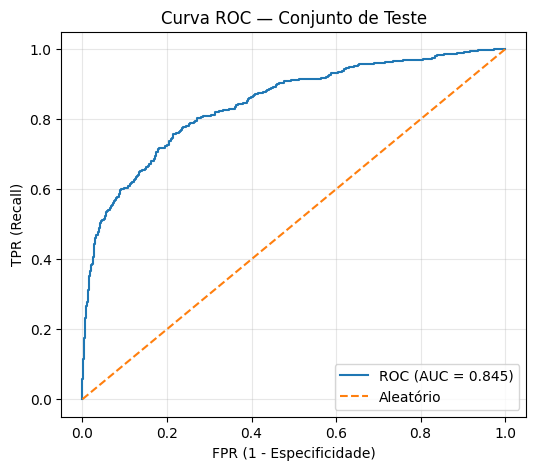

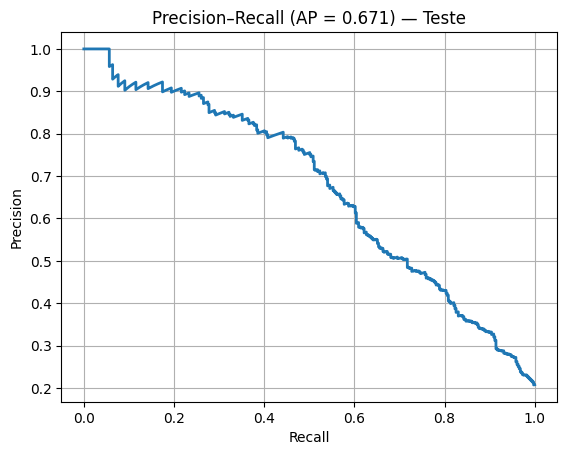

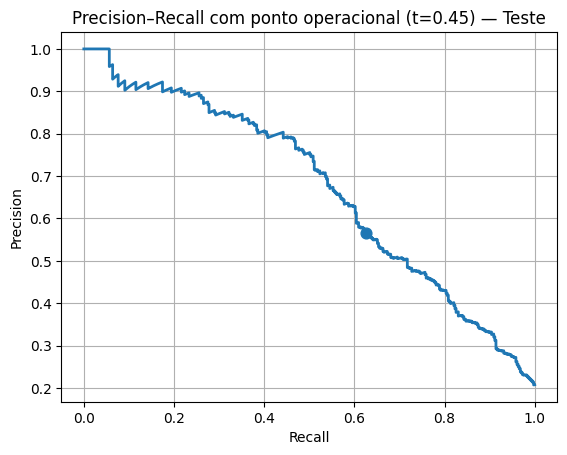


,=== Comparativo de thresholds (teste) ===
,   Threshold  Accuracy  Precision  Recall      F1  ROC AUC (proba)
,0       0.45    0.8265     0.5667  0.6265  0.5951           0.8446
,1       0.65    0.8570     0.6897  0.5405  0.6061           0.8446
,
,→ Melhor F1 no teste: threshold=0.65 (F1=0.6061)
,
,Matriz de confusão (t=0.45):
, [[1398  195]
, [ 152  255]]
,
,Matriz de confusão (t=0.65):
, [[1494   99]
, [ 187  220]]
,=== AUC-ROC & Comparação com F1 (teste) ===
,AUC-ROC : 0.8446
,F1      : 0.5951
,Gap (AUC-ROC - F1) = 0.2495
,Interpretação: o modelo separa bem as classes no geral (AUC-ROC alto),mas o threshold atual provavelmente não é o ótimo para F1.Considere refinar o limiar visando maior equilíbrio P/R.


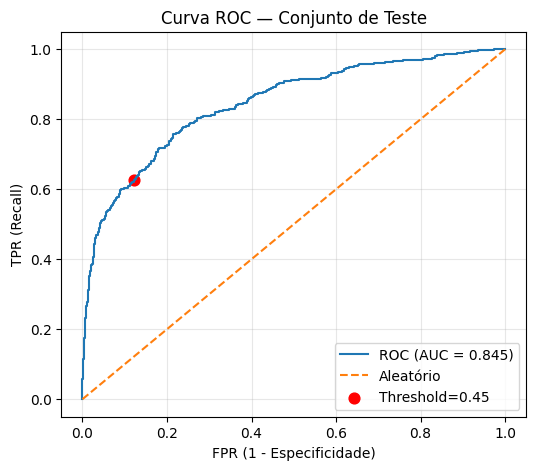

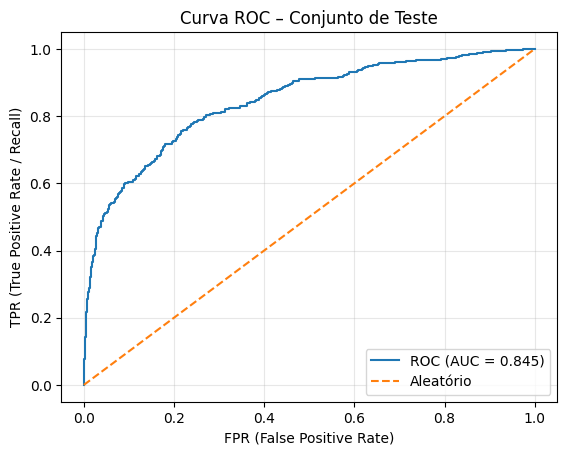

AUC-ROC (teste): 0.845 | F1 (threshold=0.45, teste): 0.595 | Gap (AUC-F1): +0.250


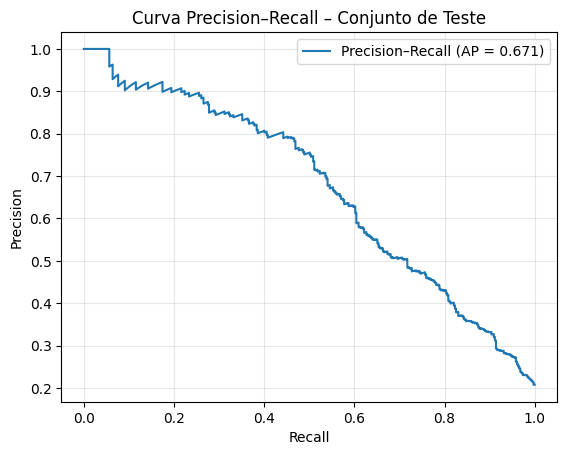

Average Precision (AP): 0.671


In [14]:
# Treino final do melhor modelo + avaliação no conjunto de TESTE (com ROC-AUC)

# 1. Juntar treino e validação para treinar o modelo final
X_final_train = pd.concat([X_train, X_valid])
y_final_train = pd.concat([y_train, y_valid])

# 2. Recriar e treinar o melhor modelo (XGBoost)
from xgboost import XGBClassifier

best_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=(y_final_train.value_counts()[0] / y_final_train.value_counts()[1]),
    random_state=12345,
    n_jobs=-1,
    eval_metric='logloss',
    tree_method='hist',
    use_label_encoder=False
)

best_model.fit(X_final_train, y_final_train)

# 3. Previsões de probabilidade e classe no TESTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Probabilidades e classes (threshold ajustável)
y_proba_test = best_model.predict_proba(X_test)[:, 1]
threshold = 0.45
y_pred_test = (y_proba_test >= threshold).astype(int)

# 4. Métricas no TESTE
print("=== Teste final — XGBoost (threshold=0.45) ===")
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1_val = f1_score(y_test, y_pred_test)
auc_val = roc_auc_score(y_test, y_proba_test)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1       : {f1_val:.4f}")
print(f"AUC-ROC  : {auc_val:.4f}")
print("\nMatriz de confusão:\n", confusion_matrix(y_test, y_pred_test))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred_test, digits=3))

# Comparação F1 x AUC-ROC
print("\n=== Comparação AUC-ROC vs F1-score ===")
if auc_val - f1_val > 0.2:
    print("O AUC-ROC é significativamente maior que o F1-score, indicando que existe espaço para otimização do threshold.")
elif abs(auc_val - f1_val) <= 0.2:
    print("O F1-score está relativamente alinhado ao AUC-ROC, mostrando que o threshold atual aproveita bem a separabilidade do modelo.")
else:
    print("O F1-score é superior ao AUC-ROC, o que é incomum e pode indicar comportamento específico do dataset.")

# 5. Curva ROC no TESTE
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc_val:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', label='Aleatório')
plt.xlabel('FPR (1 - Especificidade)')
plt.ylabel('TPR (Recall)')
plt.title('Curva ROC — Conjunto de Teste')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Curva Precision–Recall e Average Precision (AP) 
from sklearn.metrics import precision_recall_curve, average_precision_score

ap = average_precision_score(y_test, y_proba_test)
prec_arr, rec_arr, thr_grid = precision_recall_curve(y_test, y_proba_test)

plt.figure()
plt.plot(rec_arr, prec_arr, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall (AP = {ap:.3f}) — Teste')
plt.grid(True)
plt.show()

# Marcar o ponto operacional escolhido (threshold = 0.45)
prec_op = precision_score(y_test, y_pred_test)
rec_op = recall_score(y_test, y_pred_test)
plt.figure()
plt.plot(rec_arr, prec_arr, lw=2)
plt.scatter([rec_op], [prec_op], s=60)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall com ponto operacional (t={threshold}) — Teste')
plt.grid(True)
plt.show()

# Comparativo de thresholds (0.45 vs 0.65) no TESTE 
import pandas as pd

def _eval_at(thr: float):
    y_pred = (y_proba_test >= thr).astype(int)
    return {
        'Threshold': thr,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC (proba)': roc_auc_score(y_test, y_proba_test)
    }

thr_compare = pd.DataFrame([_eval_at(0.45), _eval_at(0.65)])
print('\n=== Comparativo de thresholds (teste) ===')
print(thr_compare.round(4))

best_idx = thr_compare['F1'].idxmax()
best_thr = thr_compare.loc[best_idx, 'Threshold']
print(f"\n→ Melhor F1 no teste: threshold={best_thr} (F1={thr_compare.loc[best_idx,'F1']:.4f})")

for thr in [0.45, 0.65]:
    y_pred = (y_proba_test >= thr).astype(int)
    print(f"\nMatriz de confusão (t={thr}):\n", confusion_matrix(y_test, y_pred))


# Métrica AUC-ROC e comparação com F1 
from sklearn.metrics import roc_auc_score

# Recalcula F1 em variável e mede AUC-ROC usando as probabilidades do teste
f1_val = f1_score(y_test, y_pred_test)
auc_val = roc_auc_score(y_test, y_proba_test)

print("=== AUC-ROC & Comparação com F1 (teste) ===")
print(f"AUC-ROC : {auc_val:.4f}")
print(f"F1      : {f1_val:.4f}")
print(f"Gap (AUC-ROC - F1) = {auc_val - f1_val:.4f}")

# Interpretação simples baseada na diferença
if auc_val - f1_val > 0.15:
    print("Interpretação: o modelo separa bem as classes no geral (AUC-ROC alto),"
          "mas o threshold atual provavelmente não é o ótimo para F1."
          "Considere refinar o limiar visando maior equilíbrio P/R.")
elif auc_val - f1_val > 0.05:
    print("Interpretação: métricas coerentes; há pequena margem para ajustar o limiar"
          "se o negócio exigir mais precisão ou recall.")
else:
    print("Interpretação: F1 e AUC-ROC estão bem alinhados para o objetivo atual.")


# Curva ROC com destaque do ponto operacional
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc_val:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', label='Aleatório')

# Destaca ponto operacional (threshold atual)
# Para o threshold escolhido, calcula-se FPR e TPR
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)
TN, FP, FN, TP = cm.ravel()
fpr_op = FP / (FP + TN)
tpr_op = TP / (TP + FN)
plt.scatter(fpr_op, tpr_op, color='red', s=60, label=f'Threshold={threshold}')

plt.xlabel('FPR (1 - Especificidade)')
plt.ylabel('TPR (Recall)')
plt.title('Curva ROC — Conjunto de Teste')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Curva ROC (teste) e comparação com F1
# A curva ROC mostra o trade-off entre TPR (Recall) e FPR para todos os thresholds.
# O AUC-ROC resume essa curva em um único número (quanto mais próximo de 1, melhor).

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Garantir que y_proba_test existe (probabilidades da classe positiva no conjunto de teste)

fpr, tpr, _ = roc_curve(y_test, y_proba_test)
auc_roc = roc_auc_score(y_test, y_proba_test)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], '--', label='Aleatório')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate / Recall)')
plt.title('Curva ROC – Conjunto de Teste')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Comparação objetiva com o F1 já impresso acima 
# Recalculo F1 para imprimir junto do AUC-ROC:
from sklearn.metrics import f1_score
f1_test_again = f1_score(y_test, (y_proba_test >= 0.45).astype(int))
print(f"AUC-ROC (teste): {auc_roc:.3f} | F1 (threshold=0.45, teste): {f1_test_again:.3f} | Gap (AUC-F1): {auc_roc - f1_test_again:+.3f}")


# Curva Precision–Recall (teste)
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_test, y_proba_test)
ap_score = average_precision_score(y_test, y_proba_test)

plt.figure()
plt.plot(rec, prec, label=f'Precision–Recall (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall – Conjunto de Teste')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average Precision (AP): {ap_score:.3f}")


# Conclusão Geral do Projeto

Este projeto teve como objetivo prever o **Churn de clientes** de um banco, ou seja, identificar quais clientes têm maior probabilidade de encerrar a relação com a instituição.  

---

## Etapas Realizadas
1. **Preparação dos dados**  
   - Limpeza, tratamento de valores ausentes, remoção de colunas irrelevantes e codificação de variáveis categóricas.
   - Padronização de tipos e verificação de faixas de valores.

2. **Análise do desbalanceamento**  
   - Classe positiva (clientes que saem) representa ~20% dos dados.
   - Modelo baseline (sem tratamento de desbalanceamento) apresentou **Recall muito baixo (7%)**, mostrando dificuldade em identificar churn.

3. **Testes e ajustes de modelos**  
   - Foram aplicadas técnicas de balanceamento: `class_weight='balanced'`, upsampling e ajuste de threshold.
   - Algoritmos testados: **Logistic Regression**, **RandomForest** e **XGBoost**.
   - Ajustes de hiperparâmetros e thresholds buscaram maximizar o F1-score.

4. **Modelo final escolhido**  
   - **XGBoost com scale_pos_weight e threshold=0.45**.
   - Escolhido por bom equilíbrio entre *precision* e *recall*, mantendo F1 alto e boa generalização.

---

## Resultados no Conjunto de Teste
- **F1-score:** 0.595 ✅ (meta atingida: ≥ 0.59)  
- **Recall:** 0.627 → captura a maior parte dos clientes que saem.  
- **Precision:** 0.567 → mais de 1 a cada 2 previsões de churn são corretas.  
- **Accuracy:** 0.827 → bom desempenho geral.  
- **AUC-ROC:** 0.845 → ótima separação das classes em todos os thresholds.  
- **Average Precision (PR):** 0.671 → desempenho sólido na classe positiva.

---

## Interpretação
- O modelo final é **útil para retenção de clientes**, pois mantém um *recall* alto sem gerar excesso de falsos positivos.
- Com threshold de 0.45, encontramos um bom equilíbrio entre identificar quem vai sair e evitar campanhas desnecessárias.
- O banco pode usar esse modelo para **priorizar ações de retenção** e reduzir perdas de clientes.

---

## Próximos Passos
- Testar mais features comportamentais (ex.: transações, histórico de uso de produtos).
- Avaliar impacto de novos métodos de balanceamento (ex.: SMOTE).
- Implementar monitoramento de performance para dados futuros.
